# NYCU Machine Learning 2024 : HW5 Sequential Forward Selection  and  Fisher’s Criterion

In [1]:
import numpy as np
import pandas as pd
import json
from dataclasses import dataclass, field, asdict
from pathlib import Path
from sklearn import datasets
from sklearn.utils import  Bunch
from sklearn.metrics import confusion_matrix
from lib import Lda
from rich import print
from tqdm import tqdm
from typing import Any, Callable
import matplotlib.pyplot as plt

## Load data

In [2]:
data = datasets.load_breast_cancer()
list(data.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [3]:
# print(data["DESCR"])

In [4]:
# def data_look_like()_

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['target'] = df['target'].map({0: 'malignant', 1: 'benign'})
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,malignant
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,malignant
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,malignant
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,malignant


In [5]:
POSITIVE_LABEL = "malignant"
NEGATIVE_LABEL = "benign"


In [6]:
output_folder = Path("output")
output_folder.mkdir(parents=True, exist_ok=True)

In [7]:
@dataclass(slots=True)
class FeatureSelectionDataset:
    data : dict[str, np.ndarray]
    TEST_INV_2_FOLD = {"before": "after", "after": "before"}
    
    def train_data(self, key:str) -> pd.DataFrame:
        return self.data[key]

    def test_data(self, key:str) -> pd.DataFrame:
        return self.data[self.TEST_INV_2_FOLD[key]]

    @staticmethod
    def _preprocess_data(data_in:pd.DataFrame, column_name:list[str], target_label:str) -> tuple[np.ndarray, np.ndarray]:
        
        input_data = data_in[column_name].to_numpy()
        target = data_in[target_label].to_numpy()
        
        return input_data, target

    @classmethod
    def build_dataset_for_2_fold(cls, df_in: pd.DataFrame, column_name:list[str], target_label:str = "target") :
        n = len(df_in)
        n_test = int(n * 0.5)
        n_train = n - n_test
        
        before_data , after_data = df_in[:n_train], df_in[n_train:]
        before_data = before_data[column_name + [target_label]]
        after_data = after_data[column_name + [target_label]]
        
        return cls(
            data = {
                "before": before_data,
                "after": after_data,
            }
        )
        
        

In [8]:
@dataclass(frozen=True, slots=True)
class LogResultItem:
    length: int
    features: list[str]
    balanced_cr: float
    Avg_acc: float

@dataclass(frozen=True, slots=True)
class FeatureSelectionRecord:
    method: str
    table: pd.DataFrame
    

@dataclass(frozen=True, slots=True)
class FeatureSelectionResult:
    
    selection_method_name:str
    best_result: LogResultItem
    run_log: list[LogResultItem] = field(repr=False)
    other : dict | None = None
    
    @classmethod
    def build_result(cls,name:str, run_result:list[LogResultItem], other:Any = None) :
        run_log = run_result
        best_result = max(run_result, key=lambda x : x.balanced_cr)
        other = other
        
        return cls(name, best_result, run_log, other)
    
    def save_to_json(self, folder:Path) -> None:
        folder = folder / f"{self.selection_method_name}.json"
        with open(folder, 'w') as f:
            json.dump(asdict(self), f, indent=4)
            
    def plot_log(self, folder : Path) -> None:
        folder = folder / f"{self.selection_method_name}.png"
        
        df = self.to_df()
        fig, ax = plt.subplots()
        
        ax.plot(df['length'], df['Avg_acc'], label='Avg acc', color='tab:blue')
        ax.plot(df['length'], df['balanced_cr'], label='balanced_cr', color='tab:red')
        
        ax.set_xlabel('length')
        ax.set_ylabel('Score')
        ax.set_title(self.selection_method_name)
        ax.legend()
        
        plt.tight_layout()
        
        plt.savefig(folder)
        
    def save_result(self , folder:Path) -> None:
        self.save_to_json(folder)
        self.plot_log(folder)
        
    
    def to_df(self) -> pd.DataFrame:
        return pd.DataFrame([asdict(item) for item in self.run_log])
    
    def to_record(self) -> FeatureSelectionRecord:
        
        return FeatureSelectionRecord(
            self.selection_method_name, 
            self.to_df()
        )
    
    @staticmethod
    def plot_df(df_dict_in:list[FeatureSelectionRecord] , folder:Path, title:str) -> None:
        folder = folder / f"{title}.png"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        
        for df_item in df_dict_in:
            df = df_item.table
            ax1.plot(df['length'], df['balanced_cr'], label=df_item.method)
            ax2.plot(df['length'], df['Avg_acc'], label=df_item.method)
        
        ax1.set_xlabel('length')
        ax1.set_ylabel('Balanced CR')
        ax1.set_title('Balanced CR vs Length')
        ax1.legend()
        
        ax2.set_xlabel('length')
        ax2.set_ylabel('Avg acc')
        ax2.set_title('Avg acc vs Length')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig(folder)

In [9]:
class FeatureSelection:
    
    def __init__(self, data:Bunch, model_config:dict, target_name:str="target"):
        self.data = data
        self.data_feature_names = data.feature_names
        self.target_name = target_name
        
        self.df = FeatureSelection.build_df_from_data(self.data, self.target_name)
        self.model_config = model_config
        
        self.build_dataset = lambda column_name: FeatureSelectionDataset.build_dataset_for_2_fold(self.df, column_name, self.target_name)
        
    @staticmethod
    def build_df_from_data(data_in: Bunch, target_name:str):
        df = pd.DataFrame(data_in.data, columns=data_in.feature_names)
        df[target_name] = data_in.target
        df[target_name] = df[target_name].map({0: 'malignant', 1: 'benign'})
        return df
    
    @staticmethod
    def balance_cr(y_true:np.ndarray, y_pred:np.ndarray)-> float:
        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        balance_cr = (tp / (tp + fn) +  tn / (tn + fp)) / 2          
        return balance_cr
    
    def balance_with_2_fold(self, dataset:FeatureSelectionDataset)-> tuple[float, float]:
        model = Lda(**self.model_config)
        states = ["before", "after"]
        balance, acc = [], []
        
        for state in states:
            train = dataset.train_data(state)
            test = dataset.test_data(state)
            y_test = test[[self.target_name]].copy()
            
            model.fit(data_in=train, column_name=self.target_name)
            y_pred = model.predict_with_df(test, column_name=self.target_name)
            
            balance.append(FeatureSelection.balance_cr(y_test, y_pred))
            acc.append(model.acc(test, self.target_name))
        
        return np.mean(balance), np.mean(acc)
    
    def sequential_forward_selection_term(self,features_pocket:set[str], using_features:list[str]):
        
        feature_with_score = []
            
        for feature_name in features_pocket:
            build_data_column = using_features + [feature_name]
            
            dataset = self.build_dataset(build_data_column)
            balance, acc = self.balance_with_2_fold(dataset)
        
            feature_with_score.append((build_data_column, balance, acc))
            
        max_features, max_score, avg_acc = max(feature_with_score, key=lambda x:x[1])
        
        return {"new_feature":max_features[-1], "max_features":max_features, "max_score":max_score, "avg_acc":avg_acc}
    
    def sequential_forward_selection(self):
        """
        Sequential Forward Selection (SFS)
        """
        results = []
        
        features_pocket = set(map(str, self.data_feature_names))
        using_features = []
        for i in tqdm(range(len(self.data_feature_names)), desc="SFS", unit="feature"):
            
            term_result = self.sequential_forward_selection_term(features_pocket, using_features)
            
            # add result
            results.append(LogResultItem(i+1, term_result["max_features"], term_result["max_score"], term_result["avg_acc"]))
            
            # update
            features_pocket.remove(term_result["new_feature"])
            using_features.append(term_result["new_feature"])
       
        return FeatureSelectionResult.build_result(
            name=FeatureSelection.sequential_forward_selection.__name__,
            run_result=results, 
        )
        
        
    def fisher_criterion_score(self, feature_name:str, target_label:str)-> float:
        
        data_overall = self.df[[feature_name]].mean()
        target_classes = df[target_label].unique()
        sb , sw = 0, 0
        
        for class_ in target_classes:
            data_class = df[df[target_label] == class_][feature_name]
            data_class_mean = data_class.mean()
            data_class_std = data_class.std(ddof=0)
            
            sb += len(data_class) * (data_class_mean - data_overall) ** 2
            sw += (len(data_class) / len(self.df)) *  data_class_std ** 2 
        
        fisher_score = sb / sw if sw != 0 else 0
        
        return float(fisher_score.iloc[0])
        
    def fisher_criterion(self):
        
        # find the f score of each feature
        fisher_scores = []
        for feature_name in tqdm(self.data_feature_names, desc="Fisher Score", unit="feature"):
            fisher_score = self.fisher_criterion_score(feature_name, self.target_name)
            fisher_scores.append((str(feature_name), fisher_score))
            
        # sort the feature by f score
        fisher_scores = sorted(fisher_scores, key=lambda x:x[1], reverse=True)
        fisher_scores_dict = dict(fisher_scores)
        
        ordered_features = list(fisher_scores_dict.keys())
        
        results = []
        # select the top k features
        for i in tqdm(range(len(self.data_feature_names)), desc="Fisher Score top k", unit="features"):
        
            # build dataset with the top k features
            feature_names = ordered_features[:i+1]
            dataset = self.build_dataset(feature_names)
            balance, acc = self.balance_with_2_fold(dataset)
            results.append(LogResultItem(i+1, feature_names, balance, acc))
        
        return FeatureSelectionResult.build_result(
            name=FeatureSelection.fisher_criterion.__name__,
            run_result=results, 
            other={"fisher_scores": fisher_scores_dict}
        )
       
    

In [10]:
selector = FeatureSelection(
    data=data, 
    model_config={
        "positive_class": POSITIVE_LABEL, 
        "negative_class": NEGATIVE_LABEL,
        "c1" : 1,
        "c2" : 1
    }
)

In [11]:
result = selector.sequential_forward_selection()

SFS: 100%|██████████| 30/30 [00:04<00:00,  6.12feature/s]


In [12]:
all_results = [result.to_record()]

In [13]:
print(result)

FeatureSelectionResult(
    selection_method_name='sequential_forward_selection',
    best_result=LogResultItem(
        length=15,
        features=[
            'worst concave points',
            'mean fractal dimension',
            'worst texture',
            'worst radius',
            'worst area',
            'worst smoothness',
            'mean radius',
            'worst fractal dimension',
            'symmetry error',
            'perimeter error',
            'area error',
            'smoothness error',
            'mean compactness',
            'concave points error',
            'mean smoothness'
        ],
        balanced_cr=np.float64(0.9565975936304494),
        Avg_acc=np.float64(0.9543427230046948)
    ),
    other=None
)

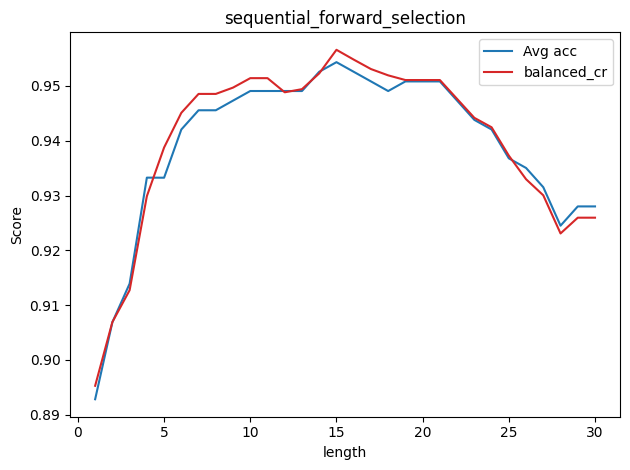

In [14]:
result.save_result(output_folder)

In [15]:
result = selector.fisher_criterion()

Fisher Score top k: 100%|██████████| 30/30 [00:00<00:00, 77.13features/s]


In [16]:
print(result)

FeatureSelectionResult(
    selection_method_name='fisher_criterion',
    best_result=LogResultItem(
        length=18,
        features=[
            'worst concave points',
            'worst perimeter',
            'mean concave points',
            'worst radius',
            'mean perimeter',
            'worst area',
            'mean radius',
            'mean area',
            'mean concavity',
            'worst concavity',
            'mean compactness',
            'worst compactness',
            'radius error',
            'perimeter error',
            'area error',
            'worst texture',
            'worst smoothness',
            'worst symmetry'
        ],
        balanced_cr=np.float64(0.9374552926611184),
        Avg_acc=np.float64(0.9368173956016803)
    ),
    other={
        'fisher_scores': {
            'worst concave points': 967.7871055979167,
            'worst perimeter': 901.1115706017904,
            'mean concave points': 864.7154415946343,
            'worst radius': 863.8179740290946,
            'mean perimeter': 699.6946561536906,
            'worst area': 663.9338923256329,
            'mean radius': 649.2631409820975,
            'mean area': 575.0821248630081,
            'mean concavity': 535.6759943735783,
            'worst concavity': 438.23229897766583,
            'mean compactness': 314.3379571516546,
            'worst compactness': 305.4145763531579,
            'radius error': 269.78861736229044,
            'perimeter error': 254.79297341154398,
            'area error': 244.51102699741585,
            'worst texture': 150.12458336219282,
            'worst smoothness': 122.90488356411787,
            'worst symmetry': 119.2794922142793,
            'mean texture': 118.51262392820716,
            'concave points error': 113.6622758530192,
            'mean smoothness': 83.94618909946027,
            'mean symmetry': 69.77269021474973,
            'worst fractal dimension': 66.67833088116858,
            'compactness error': 53.435160430159605,
            'concavity error': 39.15209877574288,
            'fractal dimension error': 3.480508530435922,
            'smoothness error': 2.566990617306365,
            'mean fractal dimension': 0.09378895729071372,
            'texture error': 0.039232602497379906,
            'symmetry error': 0.024202476904273695
        }
    }
)

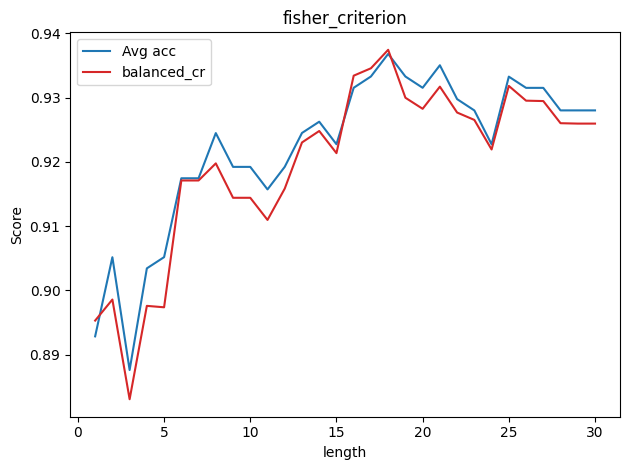

In [17]:
result.save_result(output_folder)

In [18]:
all_results.append(result.to_record())

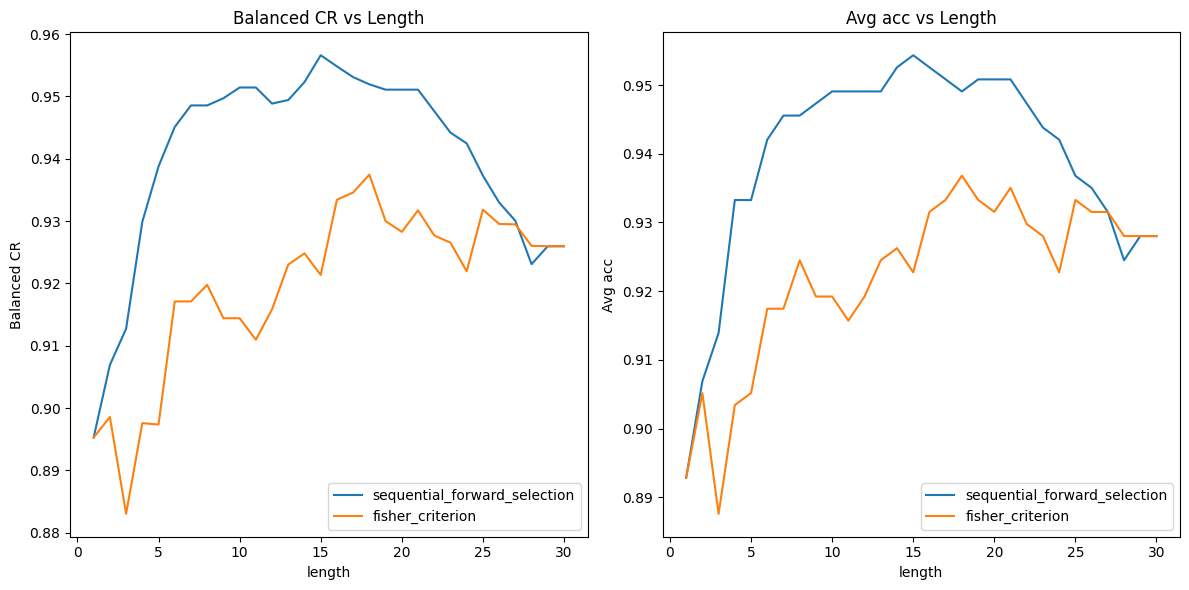

In [19]:
FeatureSelectionResult.plot_df(
    all_results,
    output_folder,
    "All"
)